In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score


In [2]:
train_data=pd.read_csv('GUIDE_Train.csv', nrows=50000)
train_data
print(list(train_data.columns))
pd.set_option('display.max_columns', None)
print(train_data.shape)
train_data.head(1)

['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City']
(50000, 45)


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  50000 non-null  int64  
 1   OrgId               50000 non-null  int64  
 2   IncidentId          50000 non-null  int64  
 3   AlertId             50000 non-null  int64  
 4   Timestamp           50000 non-null  object 
 5   DetectorId          50000 non-null  int64  
 6   AlertTitle          50000 non-null  int64  
 7   Category            50000 non-null  object 
 8   MitreTechniques     21286 non-null  object 
 9   IncidentGrade       49724 non-null  object 
 10  ActionGrouped       304 non-null    object 
 11  ActionGranular      304 non-null    object 
 12  EntityType          50000 non-null  object 
 13  EvidenceRole        50000 non-null  object 
 14  DeviceId            50000 non-null  int64  
 15  Sha256              50000 non-null  int64  
 16  IpAd

In [4]:
#Null Columns and duplicates removal 
train_data=train_data.dropna(thresh=len(train_data)* 0.5,axis=1)
print(train_data.shape)
print(train_data.duplicated().sum())
train_data.drop_duplicates(inplace=True)
train_data.isnull().sum()

(50000, 35)
13


Id                      0
OrgId                   0
IncidentId              0
AlertId                 0
Timestamp               0
DetectorId              0
AlertTitle              0
Category                0
IncidentGrade         276
EntityType              0
EvidenceRole            0
DeviceId                0
Sha256                  0
IpAddress               0
Url                     0
AccountSid              0
AccountUpn              0
AccountObjectId         0
AccountName             0
DeviceName              0
NetworkMessageId        0
RegistryKey             0
RegistryValueName       0
RegistryValueData       0
ApplicationId           0
ApplicationName         0
OAuthApplicationId      0
FileName                0
FolderPath              0
ResourceIdName          0
OSFamily                0
OSVersion               0
CountryCode             0
State                   0
City                    0
dtype: int64

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49987 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  49987 non-null  int64 
 1   OrgId               49987 non-null  int64 
 2   IncidentId          49987 non-null  int64 
 3   AlertId             49987 non-null  int64 
 4   Timestamp           49987 non-null  object
 5   DetectorId          49987 non-null  int64 
 6   AlertTitle          49987 non-null  int64 
 7   Category            49987 non-null  object
 8   IncidentGrade       49711 non-null  object
 9   EntityType          49987 non-null  object
 10  EvidenceRole        49987 non-null  object
 11  DeviceId            49987 non-null  int64 
 12  Sha256              49987 non-null  int64 
 13  IpAddress           49987 non-null  int64 
 14  Url                 49987 non-null  int64 
 15  AccountSid          49987 non-null  int64 
 16  AccountUpn          49987 n

In [6]:
#Filling the NaN values for the IncidentGrade
train_data['IncidentGrade'] = train_data['IncidentGrade'].fillna(train_data['IncidentGrade'].mode()[0])
train_data['IncidentGrade'].unique()

array(['TruePositive', 'FalsePositive', 'BenignPositive'], dtype=object)

In [7]:
#Handling DateTimes
train_data['Timestamp']=pd.to_datetime(train_data['Timestamp']) # data clean Timestamp
train_data["Day"]=train_data["Timestamp"].dt.day
train_data["Month"]=train_data["Timestamp"].dt.month
train_data["Year"]=train_data["Timestamp"].dt.year
train_data["Hour"]=train_data["Timestamp"].dt.hour
train_data["Time"]=train_data["Timestamp"].dt.time
train_data=train_data.drop("Timestamp",axis=1)   # doprring timestamp column
train_data.head(10)

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time
0,180388628218,0,612,123247,7,6,InitialAccess,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3,4,6,2024,6,06:05:15
1,455266534868,88,326,210035,58,43,Exfiltration,FalsePositive,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,14,6,2024,3,03:01:25
2,1056561957389,809,58352,712507,423,298,InitialAccess,FalsePositive,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,13,6,2024,4,04:52:55
3,1279900258736,92,32992,774301,2,2,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,10,6,2024,16,16:39:36
4,214748368522,148,4359,188041,9,74,Execution,TruePositive,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,15,6,2024,1,01:08:07
5,1322849927433,11,417400,825450,0,0,InitialAccess,FalsePositive,Ip,Related,98799,138268,30410,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,8,6,3,10,6,2024,13,13:30:56
6,163208760309,522,566,705663,2,2,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,3306,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,14,6,2024,23,23:19:45
7,1400159339557,125,38679,47423,313,3919,Exfiltration,BenignPositive,MailMessage,Impacted,98799,138268,360606,160396,441377,34744,425863,453297,153085,1082,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,6,6,2024,13,13:39:23
8,1219770713645,21,414,197969,3,4,SuspiciousActivity,BenignPositive,Process,Related,98799,0,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,0,1694,3586,5,66,242,1445,10630,9,6,2024,10,10:21:29
9,1073741827836,72,70,831157,4,3,InitialAccess,TruePositive,User,Impacted,98799,138268,360606,160396,4070,5532,4086,4256,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,8,6,2024,2,02:08:01


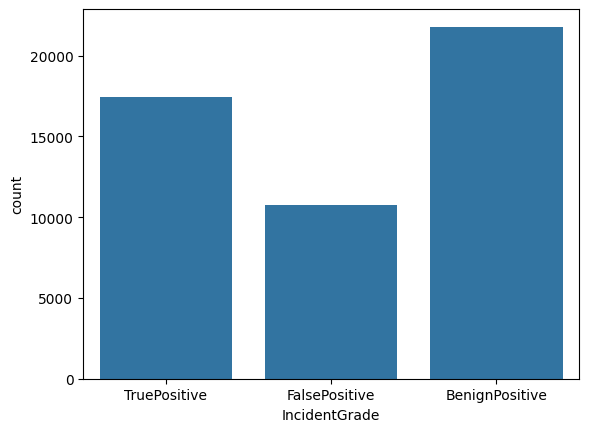

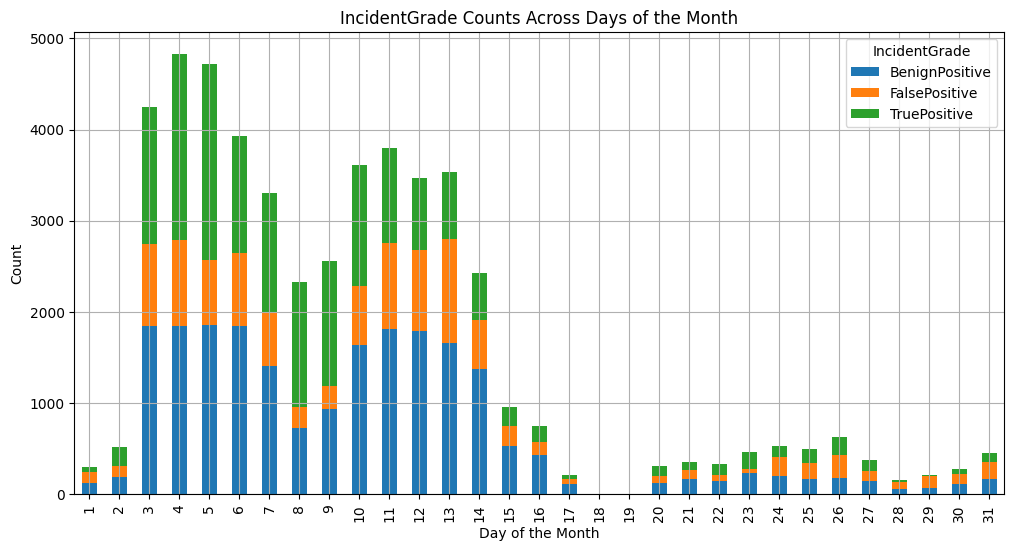

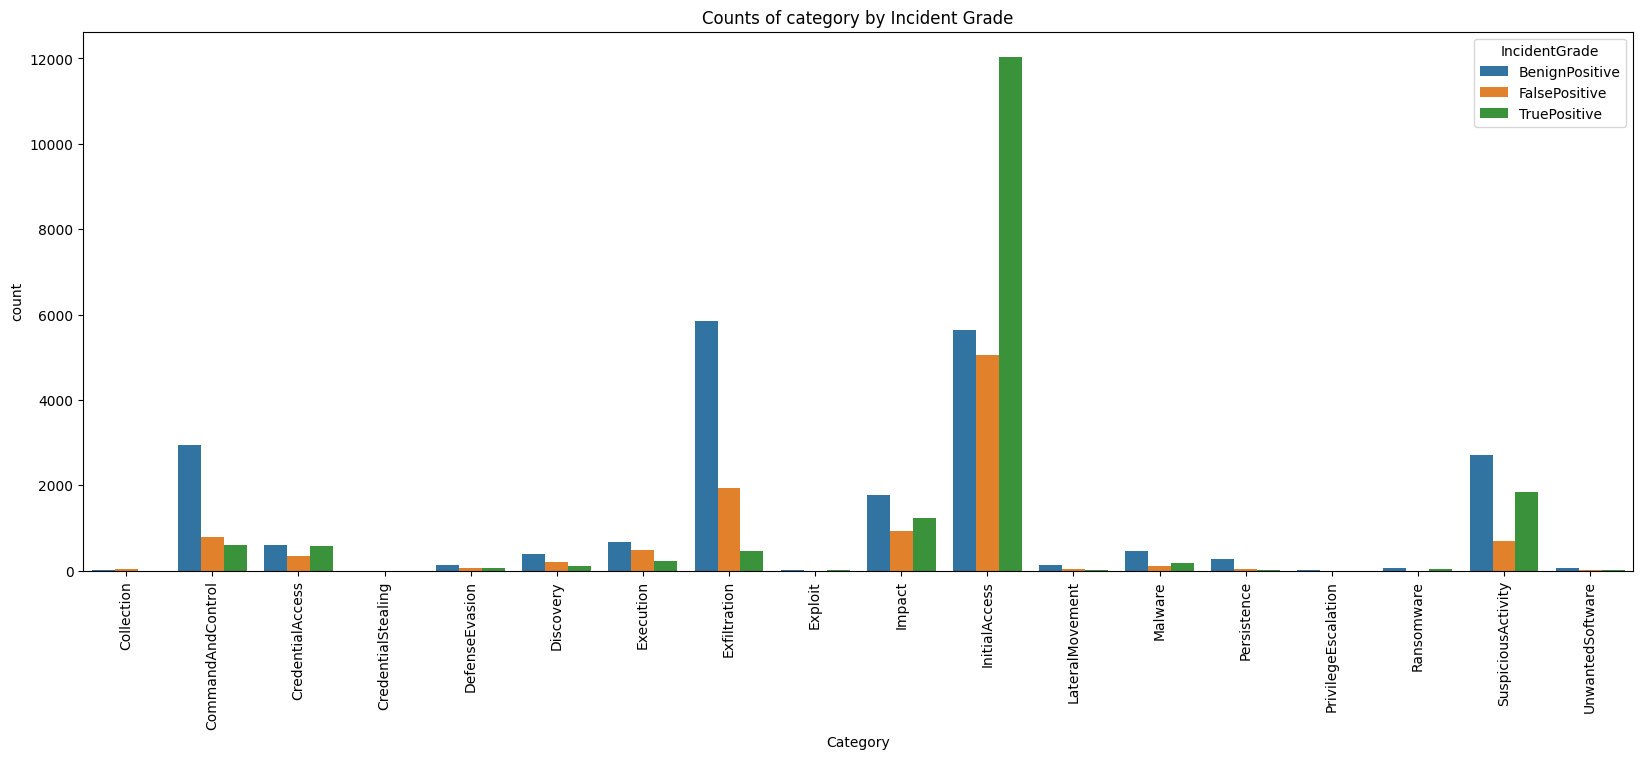

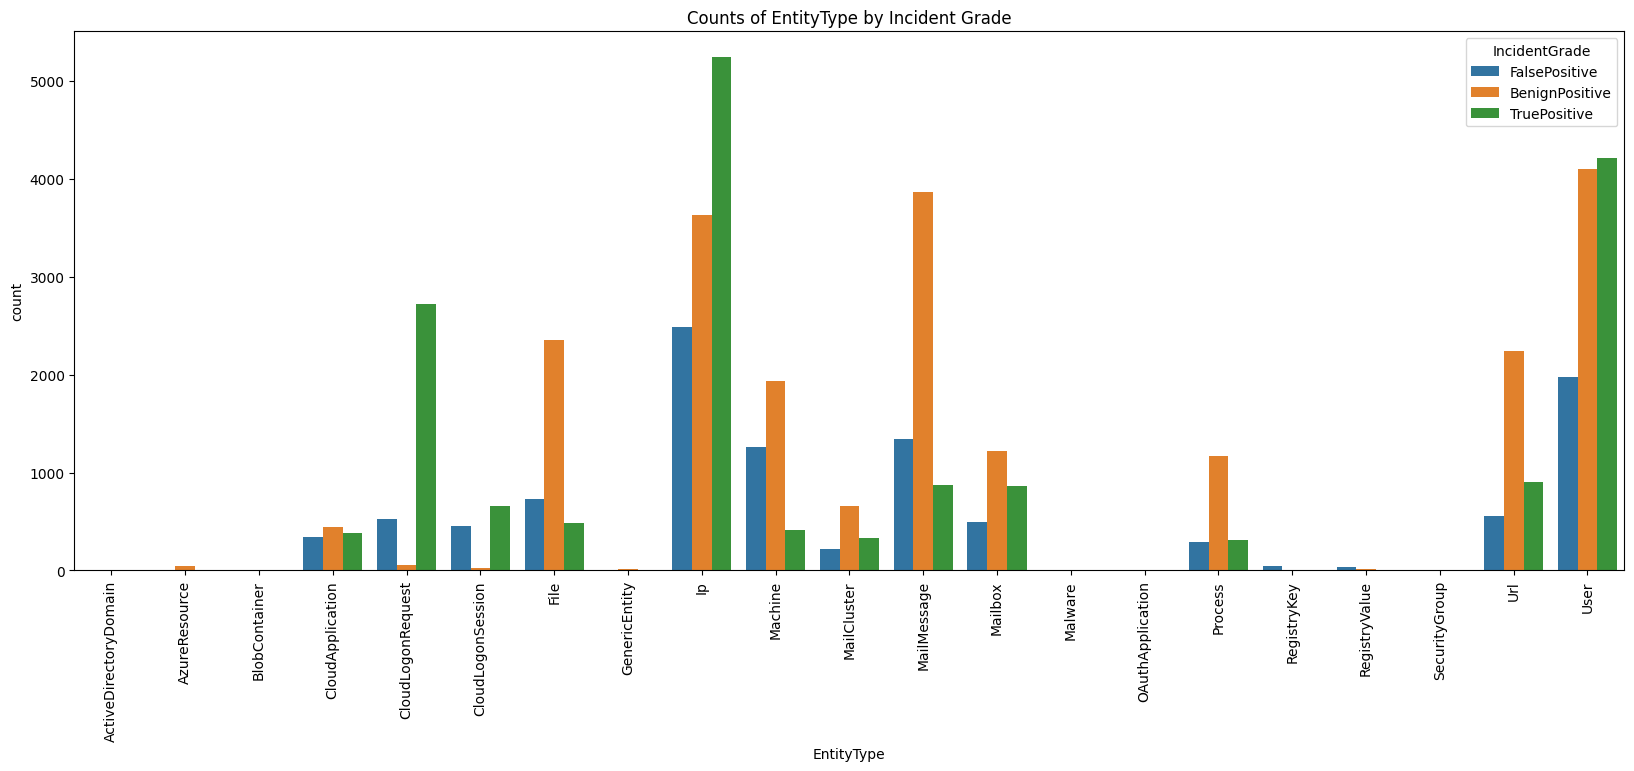

In [8]:
#Data Visualization

sns.countplot(x="IncidentGrade", data=train_data)
plt.show()

day_incident_grade = train_data.groupby(['Day', 'IncidentGrade']).size().unstack()
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

category_incident=train_data.groupby(["Category","IncidentGrade"]).size().reset_index(name="count")
plt.figure(figsize=(20,7))
sns.barplot(data=category_incident,x="Category", y="count", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of category by Incident Grade")
plt.show()

entity_incident=train_data.groupby(["EntityType","IncidentGrade"]).size().reset_index(name="count")
plt.figure(figsize=(20,7))
sns.barplot(data=entity_incident,x="EntityType", y="count", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of EntityType by Incident Grade")
plt.show()

In [9]:
train_data=train_data.drop(["Month","DeviceName","DeviceId","ResourceIdName","OAuthApplicationId","NetworkMessageId"], axis =1)
train_data.isna().sum()

Id                   0
OrgId                0
IncidentId           0
AlertId              0
DetectorId           0
AlertTitle           0
Category             0
IncidentGrade        0
EntityType           0
EvidenceRole         0
Sha256               0
IpAddress            0
Url                  0
AccountSid           0
AccountUpn           0
AccountObjectId      0
AccountName          0
RegistryKey          0
RegistryValueName    0
RegistryValueData    0
ApplicationId        0
ApplicationName      0
FileName             0
FolderPath           0
OSFamily             0
OSVersion            0
CountryCode          0
State                0
City                 0
Day                  0
Year                 0
Hour                 0
Time                 0
dtype: int64

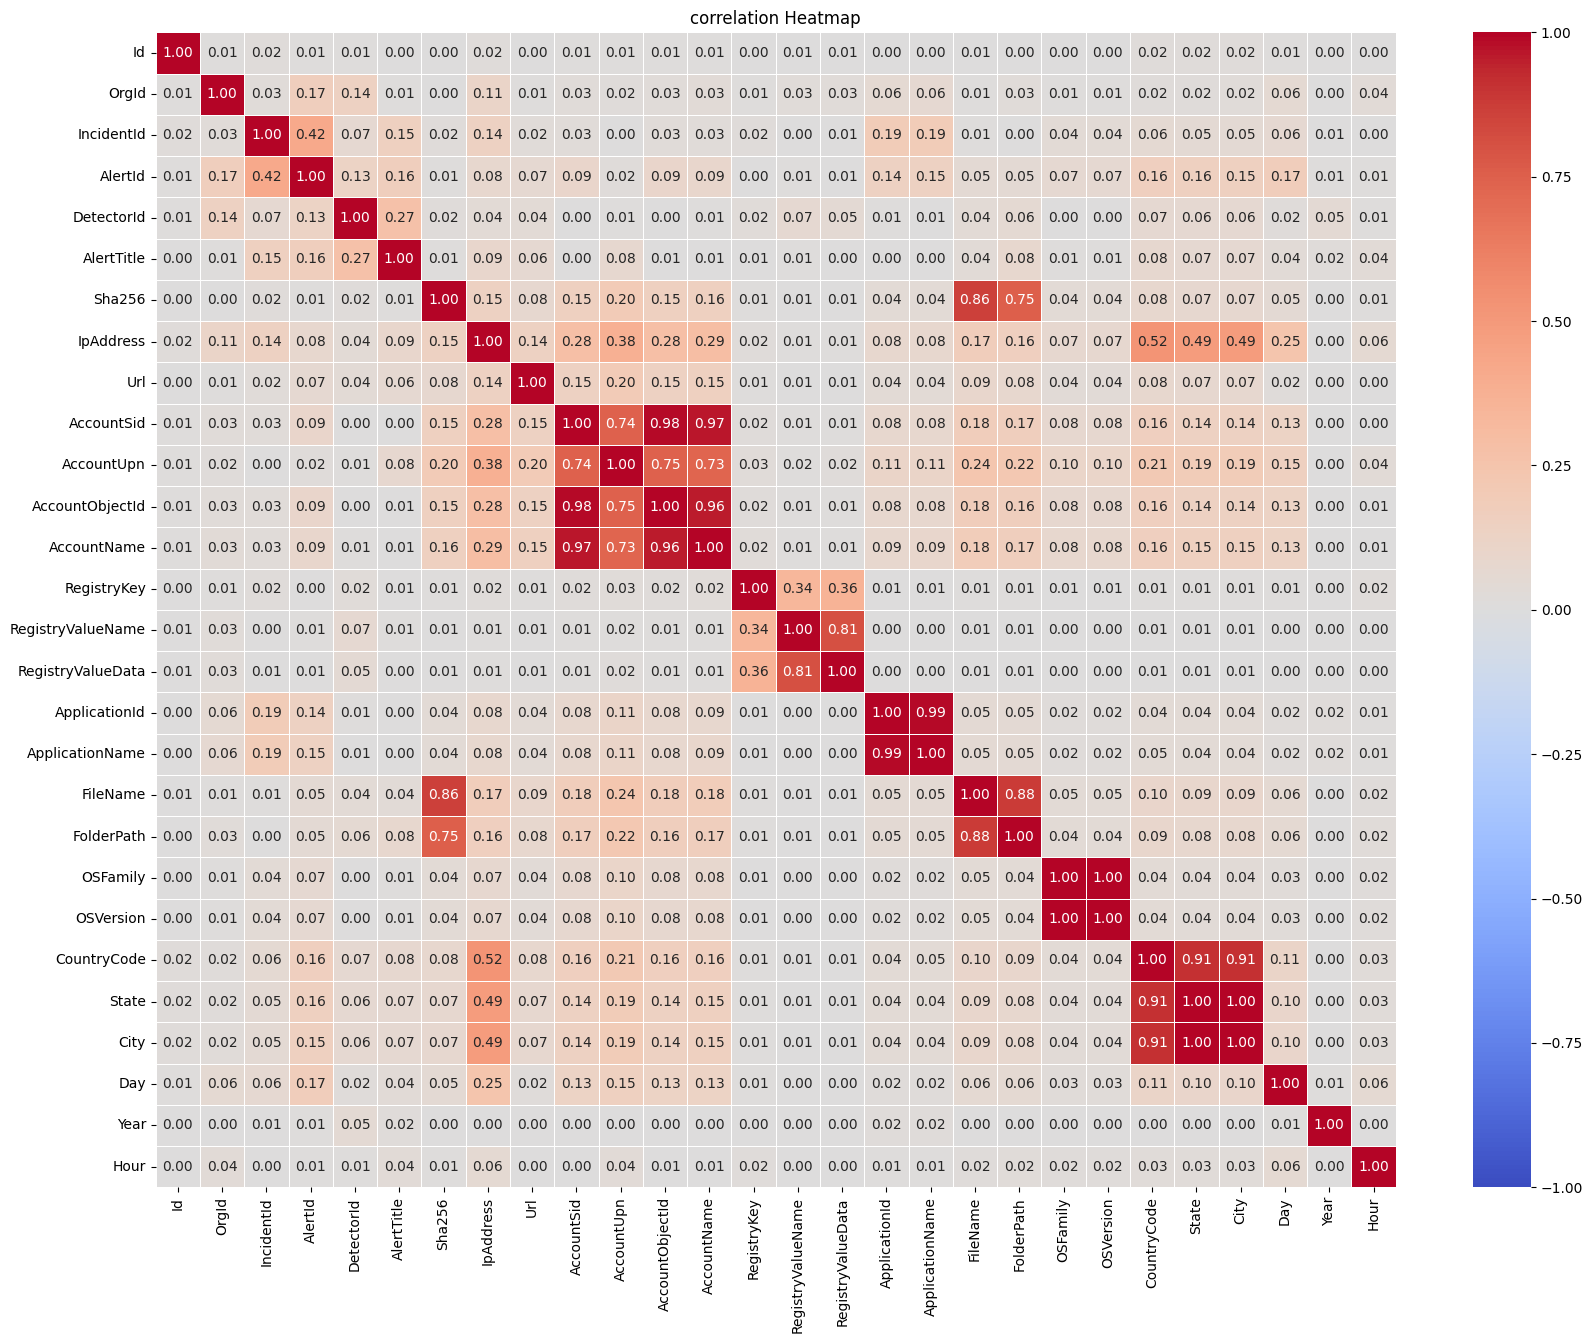

In [10]:
#Feature Selection

numeric_train_data=train_data.select_dtypes(include=['number'])
corr_matrix= numeric_train_data.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [11]:
train_data=train_data.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","AccountObjectId","FolderPath","AccountUpn"
               ,"RegistryKey","RegistryValueData","DetectorId","Id","OSFamily","OSVersion",'State',"FileName","AccountName"]
               , axis =1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49987 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OrgId          49987 non-null  int64 
 1   IncidentId     49987 non-null  int64 
 2   AlertId        49987 non-null  int64 
 3   AlertTitle     49987 non-null  int64 
 4   Category       49987 non-null  object
 5   IncidentGrade  49987 non-null  object
 6   EntityType     49987 non-null  object
 7   EvidenceRole   49987 non-null  object
 8   IpAddress      49987 non-null  int64 
 9   Url            49987 non-null  int64 
 10  ApplicationId  49987 non-null  int64 
 11  City           49987 non-null  int64 
 12  Day            49987 non-null  int32 
 13  Year           49987 non-null  int32 
 14  Hour           49987 non-null  int32 
 15  Time           49987 non-null  object
dtypes: int32(3), int64(8), object(5)
memory usage: 5.9+ MB


In [12]:
#Encoding

categorical_columns=train_data.select_dtypes(include=["object"]).columns
encoders=[]
for i in categorical_columns:
    label_encoder = LabelEncoder()
    train_data[i]=label_encoder.fit_transform(train_data[i])
    mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
    encoders.append(mapping)
    print(mapping)
encoders

{'Collection': 0, 'CommandAndControl': 1, 'CredentialAccess': 2, 'CredentialStealing': 3, 'DefenseEvasion': 4, 'Discovery': 5, 'Execution': 6, 'Exfiltration': 7, 'Exploit': 8, 'Impact': 9, 'InitialAccess': 10, 'LateralMovement': 11, 'Malware': 12, 'Persistence': 13, 'PrivilegeEscalation': 14, 'Ransomware': 15, 'SuspiciousActivity': 16, 'UnwantedSoftware': 17}
{'BenignPositive': 0, 'FalsePositive': 1, 'TruePositive': 2}
{'ActiveDirectoryDomain': 0, 'AzureResource': 1, 'BlobContainer': 2, 'CloudApplication': 3, 'CloudLogonRequest': 4, 'CloudLogonSession': 5, 'File': 6, 'GenericEntity': 7, 'Ip': 8, 'Machine': 9, 'MailCluster': 10, 'MailMessage': 11, 'Mailbox': 12, 'Malware': 13, 'OAuthApplication': 14, 'Process': 15, 'RegistryKey': 16, 'RegistryValue': 17, 'SecurityGroup': 18, 'Url': 19, 'User': 20}
{'Impacted': 0, 'Related': 1}
{datetime.time(0, 0, 11): 0, datetime.time(0, 0, 15): 1, datetime.time(0, 0, 23): 2, datetime.time(0, 0, 29): 3, datetime.time(0, 0, 31): 4, datetime.time(0, 0, 3

[{'Collection': 0,
  'CommandAndControl': 1,
  'CredentialAccess': 2,
  'CredentialStealing': 3,
  'DefenseEvasion': 4,
  'Discovery': 5,
  'Execution': 6,
  'Exfiltration': 7,
  'Exploit': 8,
  'Impact': 9,
  'InitialAccess': 10,
  'LateralMovement': 11,
  'Malware': 12,
  'Persistence': 13,
  'PrivilegeEscalation': 14,
  'Ransomware': 15,
  'SuspiciousActivity': 16,
  'UnwantedSoftware': 17},
 {'BenignPositive': 0, 'FalsePositive': 1, 'TruePositive': 2},
 {'ActiveDirectoryDomain': 0,
  'AzureResource': 1,
  'BlobContainer': 2,
  'CloudApplication': 3,
  'CloudLogonRequest': 4,
  'CloudLogonSession': 5,
  'File': 6,
  'GenericEntity': 7,
  'Ip': 8,
  'Machine': 9,
  'MailCluster': 10,
  'MailMessage': 11,
  'Mailbox': 12,
  'Malware': 13,
  'OAuthApplication': 14,
  'Process': 15,
  'RegistryKey': 16,
  'RegistryValue': 17,
  'SecurityGroup': 18,
  'Url': 19,
  'User': 20},
 {'Impacted': 0, 'Related': 1},
 {datetime.time(0, 0, 11): 0,
  datetime.time(0, 0, 15): 1,
  datetime.time(0, 0

In [13]:
train_data
train_data.to_csv('train_data_process.csv',index= False)

In [14]:
from imblearn.over_sampling import RandomOverSampler

over_sampler=RandomOverSampler(random_state = 94)
X=train_data.drop('IncidentGrade',axis=1)
y=train_data[['IncidentGrade']]
y.value_counts()

IncidentGrade
0                21797
2                17415
1                10775
Name: count, dtype: int64

In [15]:
X_over_sampler,y_over_sampler=over_sampler.fit_resample(X,y)
y_over_sampler.value_counts()

IncidentGrade
0                21797
1                21797
2                21797
Name: count, dtype: int64

In [16]:
#Feature Selection

model = RandomForestClassifier(n_estimators = 800, random_state =79)
model.fit(X_over_sampler,y_over_sampler)
selected_features=pd.DataFrame({
    "columns": X_over_sampler.columns,
    "Score": model.feature_importances_
}).sort_values('Score', ascending =False).head(15)["columns"].to_list()
X1=X_over_sampler[selected_features]
X1
X1.columns

c:\Users\mypc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Index(['OrgId', 'IncidentId', 'AlertId', 'AlertTitle', 'Day', 'Time',
       'Category', 'Hour', 'EntityType', 'IpAddress', 'City', 'Url',
       'EvidenceRole', 'ApplicationId', 'Year'],
      dtype='object')

In [17]:
#Model Building

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted)
    prec = precision_score(actual, predicted, average="macro")
    recall = recall_score(actual, predicted, average="macro")
    macro_f1 = f1_score(actual, predicted, average="macro")
    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

X_train,X_test, y_train,y_test = train_test_split(X1,y_over_sampler, test_size = 0.20, random_state = 43)

dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")
dt_model.fit(X_train,y_train)
train_dt_pred =dt_model.predict(X_train)
test_dt_pred =dt_model.predict(X_test)
dttrain_metrics=metrics(y_train,train_dt_pred)
dttest_metrics=metrics(y_test,test_dt_pred)

dt_metrics_df=pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()
dt_metrics_df

,Metrics,Training,Testing
0,Accuracy,0.673822,0.672911
1,Precision,0.728810,0.727882
2,Recall,0.674016,0.672124
3,Macro F1,0.679167,0.678370


In [18]:
rfc_model =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)
rfc_model.fit(X_train,y_train)
train_rfc_pred =rfc_model.predict(X_train)
test_rfc_pred =rfc_model.predict(X_test)
rfc_train_metrics=metrics(y_train,train_rfc_pred)
rfc_test_metrics=metrics(y_test,test_rfc_pred)

rfc_metrics_df=pd.DataFrame({
    "Training":rfc_train_metrics["Values"],
    "Testing":rfc_test_metrics["Values"]
}).reset_index()
rfc_metrics_df

c:\Users\mypc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,Metrics,Training,Testing
0,Accuracy,0.783912,0.775289
1,Precision,0.839771,0.831795
2,Recall,0.784161,0.774276
3,Macro F1,0.788256,0.779681


In [19]:
xgb_model =xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)
xgb_model.fit(X_train,y_train)
train_xgb_pred =xgb_model.predict(X_train)
test_xgb_pred =xgb_model.predict(X_test)
xgb_train_metrics=metrics(y_train,train_xgb_pred)
xgb_test_metrics=metrics(y_test,test_xgb_pred)

xgb_metrics_df=pd.DataFrame({
    "Training":xgb_train_metrics["Values"],
    "Testing":xgb_test_metrics["Values"]
}).reset_index()
xgb_metrics_df

,Metrics,Training,Testing
0,Accuracy,0.961558,0.921018
1,Precision,0.961778,0.921903
2,Recall,0.961572,0.920922
3,Macro F1,0.961564,0.921112


In [23]:
import pickle
with open('xgb_classifier_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

print("Model has been pickled successfully.")

Model has been pickled successfully.
